Using device: cpu
Loading model...
Loading data...
Loading metadata and scalers...
1. Generating and sampling data for statistical comparison...


Generating and Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [2:30:25<00:00, 501.40s/it]


Created datasets with 6331 real and 6331 generated trajectories.

2. Calculating statistical metrics...


--- Aggregate Statistics Comparison ---
                              Length (points)  Total Distance (m)  \
Type      Mode                                                      
Generated BIKE                         593.33            86497.33   
          BUS                          802.46           114464.76   
          ELECT_BIKE                   611.57            87425.49   
          ELECT_SCOOTER                346.18            52756.25   
          LIGHT_COMM_VEHICLE           761.14           112729.59   
          ON_DEMAND                   1370.29           237949.78   
          OTHER                        916.60           153272.61   
          PLANE                       1479.20           387441.88   
          PRIV_CAR_DRIVER              584.69           106162.99   
          PRIV_CAR_PASSENGER           684.56           123616.50   
          SUBWAY          

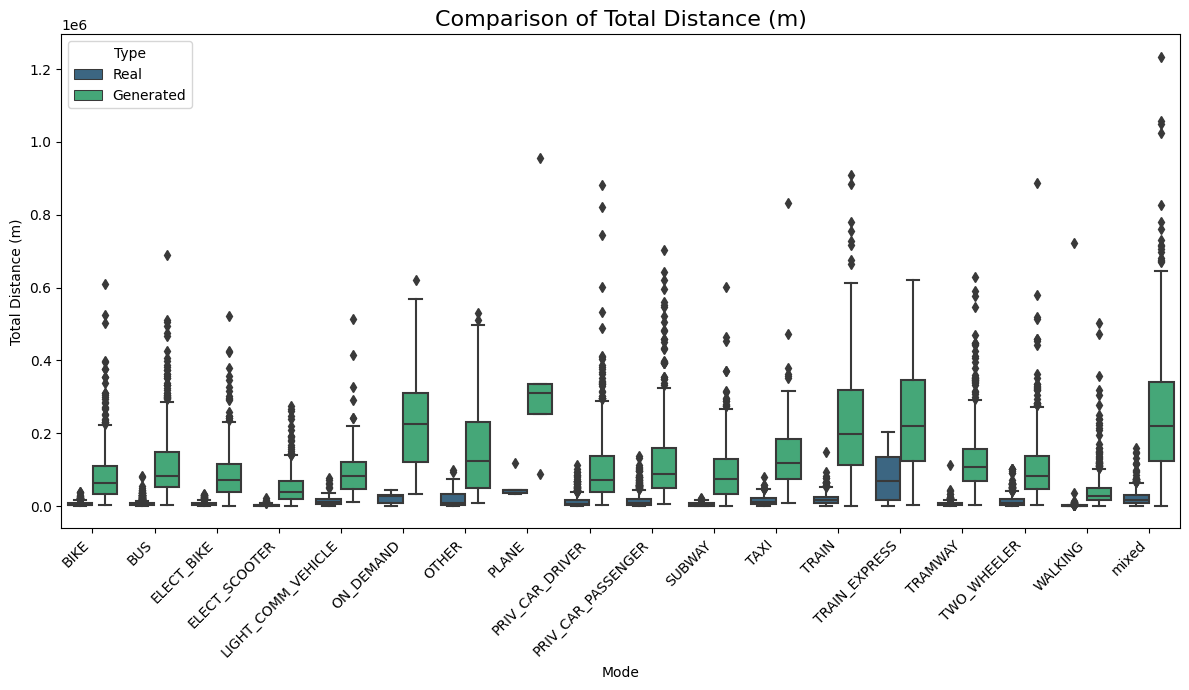

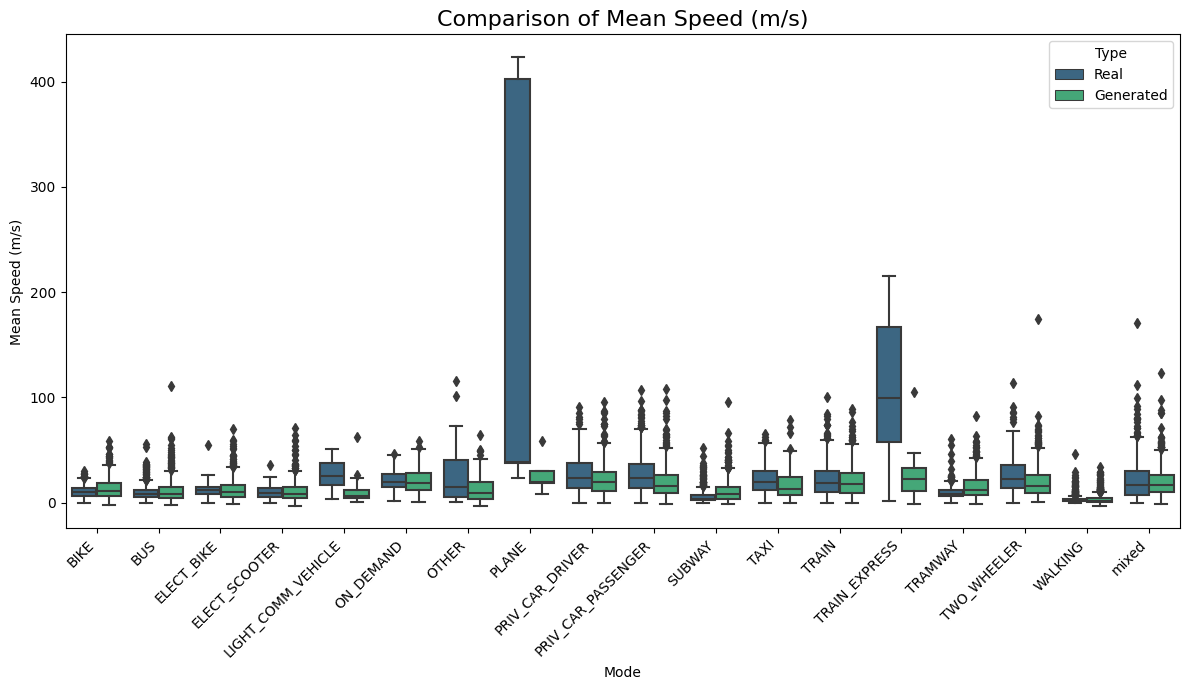

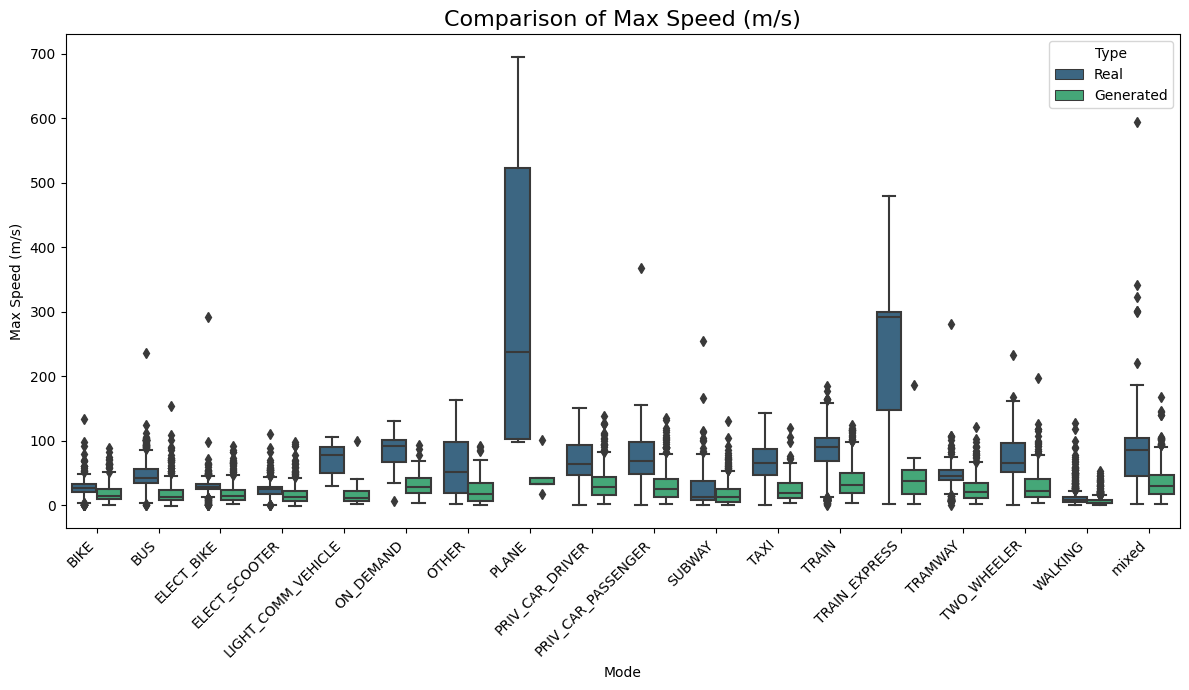

In [1]:
# %% Imports
import numpy as np
import pandas as pd
import torch
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List, Union
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
import sys
sys.path.append('../..')

from ml_mobility_ns3.models.vae import ConditionalTrajectoryVAE
from ml_mobility_ns3.utils.model_utils import load_model_from_checkpoint

# %% Configuration
MODEL_PATH = Path("../results/initial_run_attention/best_model.pt")
DATA_PATH = Path("../preprocessing/vae_dataset.npz")
PREPROCESSING_DIR = Path("../preprocessing/")

# --- Device setup ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# %% Load Model and Data
def load_vae_model_and_data(model_path, data_path, preprocessing_dir):
    """Load model, data, and all necessary components."""
    print("Loading model...")
    model, config = load_model_from_checkpoint(model_path, device)
    
    print("Loading data...")
    data = np.load(data_path)
    
    print("Loading metadata and scalers...")
    with open(preprocessing_dir / "metadata.pkl", 'rb') as f:
        metadata = pickle.load(f)
    
    with open(preprocessing_dir / "scalers.pkl", 'rb') as f:
        scalers = pickle.load(f)
    
    return model, data, metadata, scalers

model, data, metadata, scalers = load_vae_model_and_data(MODEL_PATH, DATA_PATH, PREPROCESSING_DIR)
mode_to_idx = {name: i for i, name in enumerate(metadata['transport_modes'])}
idx_to_mode = {i: name for i, name in enumerate(metadata['transport_modes'])}

# %% Data Generation and Sampling
def generate_and_sample_datasets(
    model: ConditionalTrajectoryVAE,
    data: Dict[str, np.ndarray],
    n_samples_per_mode: int = 500
) -> (List[Dict], List[Dict]):
    """Generate and sample large datasets for statistical comparison."""
    all_generated = []
    all_real = []
    
    trajectory_scaler = scalers['trajectory']
    
    for mode_name, mode_idx in tqdm(mode_to_idx.items(), desc="Generating and Sampling"):
        # --- Real Data ---
        real_indices = np.where(data['transport_modes'] == mode_idx)[0]
        if len(real_indices) > 0:
            sample_indices = np.random.choice(real_indices, min(n_samples_per_mode, len(real_indices)), replace=False)
            
            for idx in sample_indices:
                length = int(data['trip_lengths'][idx])
                unscaled_traj = trajectory_scaler.inverse_transform(data['trajectories'][idx, :length, :])
                all_real.append({'trajectory': unscaled_traj, 'mode': mode_name})
                
                # --- Generation ---
                # Generate a trajectory of similar length to a real one
                gen_length = length 
                
                mode_tensor = torch.tensor([mode_idx], dtype=torch.long, device=device)
                length_tensor = torch.tensor([gen_length], dtype=torch.long, device=device)
    
                with torch.no_grad():
                    generated = model.generate(mode_tensor, length_tensor, n_samples=1, device=device)
                
                gen_unscaled = trajectory_scaler.inverse_transform(generated.cpu().numpy()[0, :gen_length, :])
                all_generated.append({'trajectory': gen_unscaled, 'mode': mode_name})

    return all_real, all_generated

# %% Statistical Metrics Calculation
def calculate_trajectory_stats(
    trajectories: List[Dict], 
    data_type: str
) -> pd.DataFrame:
    """Calculate a set of statistical metrics for a list of trajectories."""
    results = []
    
    for traj in trajectories:
        data = traj['trajectory']
        
        # Calculate distances (approximate conversion to meters)
        diffs = np.diff(data[:, :2], axis=0) * 111000
        step_distances = np.sqrt(np.sum(diffs**2, axis=1))
        
        # Speeds
        speeds = data[:, 2]
        
        results.append({
            'Type': data_type,
            'Mode': traj['mode'],
            'Length (points)': len(data),
            'Total Distance (m)': np.sum(step_distances),
            'Mean Speed (m/s)': np.mean(speeds),
            'Max Speed (m/s)': np.max(speeds),
            'Speed Std Dev': np.std(speeds)
        })
        
    return pd.DataFrame(results)

# %% --- Main Execution ---
# 1. Generate and sample large datasets
print("1. Generating and sampling data for statistical comparison...")
# Note: Increasing n_samples_per_mode gives more robust stats but takes longer.
real_dataset, generated_dataset = generate_and_sample_datasets(model, data, n_samples_per_mode=500)
print(f"Created datasets with {len(real_dataset)} real and {len(generated_dataset)} generated trajectories.")

# 2. Calculate statistical metrics
print("\n2. Calculating statistical metrics...")
real_stats_df = calculate_trajectory_stats(real_dataset, 'Real')
generated_stats_df = calculate_trajectory_stats(generated_dataset, 'Generated')
combined_stats_df = pd.concat([real_stats_df, generated_stats_df])

# 3. Display and Visualize Comparison
print("\n\n--- Aggregate Statistics Comparison ---")
# Display mean values grouped by Type and Mode
display_stats = combined_stats_df.groupby(['Type', 'Mode']).mean().round(2)
print(display_stats)

# --- Visualization ---
print("\n\n3. Visualizing statistical distributions...")
metrics_to_plot = ['Total Distance (m)', 'Mean Speed (m/s)', 'Max Speed (m/s)']
for metric in metrics_to_plot:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=combined_stats_df, x='Mode', y=metric, hue='Type', palette='viridis')
    plt.title(f'Comparison of {metric}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()